In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

import torch
import torch.nn as nn  # neural network modules
import torch.nn.functional as F  # activation functions
import torch.optim as optim  # optimizer
from torch.autograd import Variable # add gradients to tensors
from torch.nn import Parameter # model parameter functionality 

In [2]:
# Target labels
label_encodings3 = {
    'pants-fire': 0, 
    'false':      0, 
    'barely-true':1, 
    'half-true':  1, 
    'mostly-true':2,
    'true':       2
}
label_encodings6 = {
    'pants-fire': 0, 
    'false':      1, 
    'barely-true':2, 
    'half-true':  3, 
    'mostly-true':4,
    'true':       5
}

### DNN-TF-IDF Model

In [3]:
def vectorize_list(lst, length=1):
    # Generate corpus
    corpus = list(lst[0])
    for i in range(1,len(lst)):
        corpus.extend(list(lst[i]))
    # Vectorize
    vectorizer = TfidfVectorizer(stop_words = 'english', 
                                 ngram_range=(1,length))
    vectorizer.fit(corpus)
    # Collect vectors
    results = []
    for item in lst:
        temp = vectorizer.transform(list(item)).toarray()
        temp = torch.Tensor(temp)
        results.append(temp)
    
    return results

In [4]:
class DNN(nn.Module):
    def __init__(self, corpus_size, num_classes):
        super(DNN, self).__init__()
        
        self.full_1 = nn.Linear(corpus_size, 1024)
        self.drop_1 = nn.Dropout(p=0.2)
        self.nonl_1 = nn.ReLU()
        
        self.full_2 = nn.Linear(1024, 256)
        self.drop_2 = nn.Dropout(p=0.2)
        self.nonl_2 = nn.ReLU()

        self.full_3 = nn.Linear(256, 64)
        self.drop_3 = nn.Dropout(p=0.2)
        self.nonl_3 = nn.ReLU()

        self.full_4 = nn.Linear(64, 16)
        self.drop_4 = nn.Dropout(p=0.2)
        self.nonl_4 = nn.ReLU()
        
        self.full_5 = nn.Linear(16, num_classes)
        self.drop_5 = nn.Dropout(p=0.2)
        self.nonl_5 = nn.Softmax()
        
    def forward(self, x):
        result = self.nonl_1(self.drop_1(self.full_1(x)))
        result = self.nonl_2(self.drop_2(self.full_2(result)))
        result = self.nonl_3(self.drop_3(self.full_3(result)))
        result = self.nonl_4(self.drop_4(self.full_4(result)))
        result = self.nonl_5(self.drop_5(self.full_5(result)))
        return result

In [5]:
def get_accuracy(output, targets):

    predicted = [int(y_pred.detach().argmax(-1)) for y_pred in output]
    targets = [int(y) for y in targets]
    correct = sum(a==b for (a,b) in zip(predicted, targets))
    accuracy = 100*correct/len(targets) 

    return accuracy

def train(train_X,
          test_X,
          train_y,
          test_y,
          corpus_size,
          num_classes = 3,
          num_epochs = 10,
          batch_size = 100,
          learning_rate = 0.01):
    
    # Instantiate model & optimization 
    model = DNN(corpus_size, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Prepare test data
    test_y = torch.Tensor(test_y.values).to(dtype=torch.long)
    
    # Collect loss
    loss_func = nn.CrossEntropyLoss()
    loss_train, loss_test = [], []

    # Iterate over epochs
    for ep in range(num_epochs):
        
        model.train()
        temp_loss = []
        
        # Iterate over batches
        for i in range(train_X.shape[0]//batch_size):
            # Reset gradients
            optimizer.zero_grad()
            
            # Declare features and target labels
            X = train_X[i*batch_size:(i+1)*batch_size]
            y = train_y[i*batch_size:(i+1)*batch_size].values
            y = torch.Tensor(y).to(dtype=torch.long)

            # Get predictions from model
            pred = model(X)

            # Calculate loss
            loss = loss_func(pred, y)
            temp_loss.append(float(loss.detach()))
            
            # Backpropagate
            loss.backward()

            # Update parameters
            optimizer.step()
        
        # Record train loss
        loss_train.append(sum(temp_loss)/len(temp_loss))
        
        # Evaluate model
        model.eval()
            
        # Evaluate on test data
        test_pred = model(test_X)
        test_accuracy = get_accuracy(test_pred, test_y)
        loss_test.append(float(loss_func(test_pred, test_y).detach()))
        
        # Print accuracy
        print(f"Test accuracy: {test_accuracy} at epoch: {ep}")

    return model, loss_train, loss_test

### Train

In [6]:
# Read in data
df_train = pd.read_csv("Data/liar_dataset/train.csv")
df_test = pd.read_csv("Data/liar_dataset/test.csv")
df_valid = pd.read_csv("Data/liar_dataset/valid.csv")

# Relabel
df_train['target'] = df_train['label'].apply(lambda x: label_encodings6[x])
df_test['target'] = df_test['label'].apply(lambda x: label_encodings6[x])
df_valid['target'] = df_valid['label'].apply(lambda x: label_encodings6[x])

In [7]:
# TF-IDF 
vec_unigrams = vectorize_list([df_train['statement'],
                               df_test['statement'],
                               df_valid['statement']])
vec_bigrams = vectorize_list([df_train['statement'],
                              df_test['statement'],
                              df_valid['statement']],
                            length=2)

In [11]:
model, loss_train, loss_test = train(train_X=vec_bigrams[0], 
                                     test_X=vec_bigrams[1], 
                                     train_y=df_train['target'], 
                                     test_y=df_test['target'],
                                     corpus_size=vec_bigrams[0].shape[1],
                                     num_classes=6,
                                     num_epochs=10,
                                     learning_rate=1e-4,
                                     batch_size=10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test accuracy: 19.021310181531177 at epoch: 0
Test accuracy: 21.86266771902131 at epoch: 1
Test accuracy: 21.941594317284924 at epoch: 2
Test accuracy: 22.257300710339383 at epoch: 3
Test accuracy: 22.099447513812155 at epoch: 4
Test accuracy: 22.888713496448304 at epoch: 5
Test accuracy: 22.099447513812155 at epoch: 6
Test accuracy: 22.573007103393845 at epoch: 7
Test accuracy: 21.152328334648775 at epoch: 8
Test accuracy: 22.02052091554854 at epoch: 9


In [12]:
# Evaluate on validation set
pred_valid = model(vec_bigrams[2])
get_accuracy(pred_valid, 
             torch.Tensor(df_valid['target'].values).to(dtype=torch.long))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


20.24922118380062

[[  0  24   5  55   1  31]
 [  0  58   6 149   3  47]
 [  0  43  11 139   1  43]
 [  0  49   5 144   4  46]
 [  0  26   8 164  13  40]
 [  0  22   0 107   6  34]]


<AxesSubplot:>

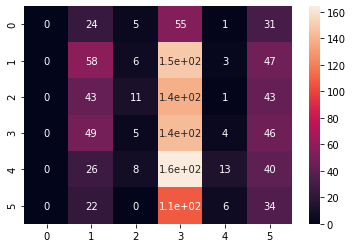

In [15]:
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import confusion_matrix
pred_valid_values = [np.argmax(pred_valid[i].detach().numpy(),0) for i in range(pred_valid.shape[0])]
cf_matrix = confusion_matrix(df_valid['target'].values, pred_valid_values)
print(cf_matrix)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [16]:
# Save losses
import pickle
with open('dnn_bigrams_loss_train.data', 'wb') as filehandle:
    pickle.dump(loss_train, filehandle)
with open('dnn_bigrams_loss_test.data', 'wb') as filehandle:
    pickle.dump(loss_test, filehandle)
    
# Save model
torch.save(model.state_dict(), "dnn_bigrams_model.pt")